## AIMI High School Internship 2024
### Notebook 2: Training a Computer Vision Model to Classify Pneumonia

**The Problem**: Given a chest X-ray, our goal in this project is to classify the image into one of four classes: **pneumonia, pneumothorax, pleural effusion**, and **normal**.  

**Your Second Task**: You should now have a training dataset consisting of (a) chest X-rays and (b) labels extracted from radiologist reports processed using NLP or a similar technique. Now, your goal is to train a computer vision model to classify the images. You have **two options** for this task, and you may attempt one or both of these:
- *Standard Classification* : Train a model to predict which class of pneumonia a chest x-ray belongs to using image-only derived features.
- *Classification w/ Metadata (stretch)*: Train a model that predicts which class of pneumonia a chest x-ray belongs to using image and additional patient metadata-derived features.

In this notebook, we provide some simple starter code to get you started on training a computer vision model. You are not required to use this template - feel free to modify as you see fit.

**Submitting Your Model**: We have created a leaderboard where you can submit your model and view results on the held-out test set. We provide instructions below for submitting your model to the leaderboard. **Please follow these directions carefully**.

We will evaluate your results on the held-out test set with the following evaluation metrics:
- **Accuracy**: the ratio of correctly predicted observations to the total observations. It tells us the proportion of true results (both true positives and true negatives) among the total number of cases examined. While straightforward, accuracy can be misleading in the context of imbalanced datasets where the number of observations in different classes varies significantly.
- **AUROC (Area Under the Receiver Operating Characteristic curve)**: a performance measurement for classification problems at various threshold settings. It tells us how well a model is capable of distinguishing between classes. The higher the AUROC, the better the model is at predicting 0s as 0s and 1s as 1s. An AUROC of 0.5 suggests no discriminative ability (equivalent to random guessing), while an AUROC of 1.0 indicates perfect discrimination.
- **Precision**: the ratio of correctly predicted positive observations to the total predicted positives. It is a measure of a classifier's exactness. High precision indicates a low false positive rate. It's particularly useful when the costs of False Positives are high.
- **Recall**: (also known as sensitivity) the ratio of correctly predicted positive observations to the all observations in actual class - yes. It is a measure of a classifier's completeness. High recall indicates that the class is correctly recognized (a low number of False Negatives).
- **F1**: the harmonic mean of precision and recall. It's a way to combine both precision and recall into a single measure that captures both properties. This score can be particularly useful if you need to balance precision and recall, which is often the case in uneven class distribution scenarios. The F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

## Load Data
Before you begin, make sure to go to `Runtime` > `Change Runtime Type` and select a T4 GPU.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir(r'/content/drive/MyDrive/Cody - AIMI 2024/2024 AIMI Summer Internship - Intern Materials/Datasets')

In [ ]:
!unzip -qq student_data_split.zip -d /content/

In [ ]:
# Switch back to /content/student_data_split folder to work with downloaded datasets
os.chdir(r'/content/student_data_split')

In [ ]:
# Confirm we can now see the student_test and student_train folders + Reports.json
!ls

Reports.json  student_test  student_train


## Import Libraries
We are leveraging the PyTorch framework to train our models. For more information and tutorials on PyTorch, see this link: https://pytorch.org/tutorials/beginner/basics/intro.html

In [ ]:
%%capture
%pip install "comet_ml>=3.38.0" torch torchvision tqdm
from comet_ml import Experiment
from comet_ml.integration.pytorch import watch

In [ ]:
# Some libraries that you may find useful are included here.
# To import a library that isn't provided with Colab, use the following command: !pip install <package_name>
import torch
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
from torchvision.transforms import v2
from torch import nn
from torchvision import models


In [ ]:
# Load your image paths and extracted labels from your saved file
#dataset = pd.read_pickle("/content/drive/MyDrive/Cody - AIMI 2024/conditionsDf.pkl")
dataframe = pd.read_pickle("/content/drive/MyDrive/Cody - AIMI 2024/train_data.pkl")


# Display the first few rows of the DataFrame to confirm it's loaded correctly
dataframe.head()

,Patient ID,Study ID,Image Path,Label,Encoded Labels
0,patient39668,student_train/patient39668/study2,student_train/patient39668/study2/view1_fronta...,normal,"[0.0, 0.0, 0.0, 1.0]"
1,patient17014,student_train/patient17014/study2,student_train/patient17014/study2/view1_fronta...,pneumothorax,"[0.0, 1.0, 0.0, 0.0]"
2,patient11443,student_train/patient11443/study1,student_train/patient11443/study1/view1_fronta...,pneumothorax,"[0.0, 1.0, 0.0, 0.0]"
3,patient29294,student_train/patient29294/study1,student_train/patient29294/study1/view1_fronta...,"pneumothorax, pleural effusion","[0.0, 1.0, 1.0, 0.0]"
4,patient34615,student_train/patient34615/study71,student_train/patient34615/study71/view1_front...,pleural effusion,"[0.0, 0.0, 1.0, 0.0]"


## Create Dataloaders
We will implement a custom Dataset class to load in data. A custom Dataset class must have three methods: `__init__`, which sets up any class variables, `__len__`, which defines the total number of images, and `__getitem__`, which returns a single image and its paired label.

In [ ]:
from torch.utils.data import Dataset

class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, transforms):
        #super(ChestXRayDataset, self).__init__(**kwargs)

        self.dataframe = dataframe
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)


    def __getitem__(self, idx):
        out_dict = {"idx": torch.tensor(idx),}

        image_path = self.dataframe.loc[idx,'Image Path']
        labels = self.dataframe.loc[idx,'Encoded Labels']

        image = Image.open(image_path).convert("RGB")
        #image = torch.tensor(image, dtype=torch.float32)
        if(self.transforms is not None):
            image = self.transforms(image)

        out_dict["img"] = image
        out_dict["label"] = torch.tensor(labels, dtype=torch.float32)

        #return out_dict
        return out_dict["img"], out_dict["label"]
        #image, target

## Define Training Components
Here, define any necessary components that you need to train your model, such as the model architecture, the loss function, and the optimizer.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

In [ ]:
#hyperparameters

batch_size = 64
learning_rate = 1e-4

k_folds = 5
num_epochs_per_k = 25

save_every_x_epochs = 2

current_epoch = 0


In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()

transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(224, 224), antialias=True),
    #v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ChestXRayDataset(dataframe, transforms)
#dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size="""Customize batch size""", shuffle=True, drop_last=True)

num_classes = 4
label_space = ['pneumonia', 'pneumothorax', 'pleural effusion', 'normal']

model = Resnext50(num_classes)
model.to(device)
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate) # AdamW is a commonly-used optimizer. Feel free to modify.



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 63.2MB/s]


In [ ]:
experiment = Experiment(
  api_key="REDACTED",
  project_name="aimi2024-resnext50",
  workspace="summit"
)
watch(model)


## Training Code
We provide starter code below that implements a simple training loop in PyTorch. Feel free to modify as you see fit.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, roc_auc_score

def calculate_metrics(pred, target, threshold=0.5):
    thresholded_preds = np.empty_like(pred)
    thresholded_preds[:] = pred
    thresholded_preds = np.array(thresholded_preds > threshold, dtype=float)

    f1 = f1_score(y_true=target, y_pred=thresholded_preds, average=None)
    f1_macro = f1_score(y_true=target, y_pred=thresholded_preds, average='macro')

    auc = roc_auc_score(y_true=target, y_score=pred, average=None)
    auc_macro = roc_auc_score(y_true=target, y_score=pred, average='macro')

    return {'f1': f1, 'f1_macro': f1_macro, 'auc': auc, 'auc_macro': auc_macro}

In [ ]:
def train_one_epoch():
      train_loss = 0.0

      for index, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)

        opt.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        opt.step()

        train_loss += loss.item() * inputs.size(0)

      train_loss /= len(train_loader.dataset)
      return train_loss

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=k_folds, shuffle=True)
threshold = 0.5

best_macro_f1 = 0.0 #higher f1 score is better, 1 is best

trainingEpoch_loss = []
validationEpoch_loss = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"\nFold {fold + 1}")
    print("-------")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=train_subsampler,
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=val_subsampler,
    )


    # Epoch loop
    for epoch in range(0, num_epochs_per_k):
      current_epoch += 1
      print(f"Training epoch {current_epoch}")

      model.train()
      train_loss = train_one_epoch()
      val_loss = 0.0

      print(f"Evaluating...")
      model.eval()

      with torch.no_grad():
        total_results = []
        total_targets = []

        for index, (data, target) in enumerate(tqdm(val_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)

            total_results.extend(output.cpu().numpy())
            total_targets.extend(target.cpu().numpy())

            val_loss += loss_fn(output, target).item() * target.size(0)

      val_loss /= len(val_loader.dataset)

      trainingEpoch_loss.append(train_loss)
      validationEpoch_loss.append(val_loss)

      metrics = calculate_metrics(np.array(total_results), np.array(total_targets))
      print(f'LOSS: train {train_loss} valid {val_loss}')
      print(f'Macro F1 Score: {metrics["f1_macro"]}   Class Breakdown: {metrics["f1"]}')
      print(f'Macro AUROC: {metrics["auc_macro"]}   Class Breakdown: {metrics["auc"]}')

      #Log to Comet
      experiment.log_metric("train loss", train_loss, epoch=current_epoch)
      experiment.log_metric("val loss", val_loss, epoch=current_epoch)
      experiment.log_metric("macro f1", metrics["f1_macro"], epoch=current_epoch)
      experiment.log_metric("macro auroc", metrics["auc_macro"], epoch=current_epoch)

      #Save best checkpoint based on F1 Score
      #F1 Score preferred over AUROC b/c of data imbalance - https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc
      if(metrics["f1_macro"] > best_macro_f1):
          best_macro_f1 = metrics["f1_macro"]
          state = {
              'epoch': current_epoch,
              'state_dict': model.state_dict(),
              'optimizer': opt.state_dict(),
          }
          save_path = f'/content/drive/MyDrive/Cody - AIMI 2024/Trains/best.ckpt'
          torch.save(state, save_path)

      #Save every x epochs
      if(current_epoch % save_every_x_epochs == 0):
          save_path = f'/content/drive/MyDrive/Cody - AIMI 2024/Trains/model-fold-{fold+1}-epoch-{current_epoch}.pth'
          torch.save(model.state_dict(), save_path)  # Save model weights for inference



Fold 1
-------
Training epoch 1


100%|██████████| 210/210 [05:02<00:00,  1.44s/it]


Evaluating...


100%|██████████| 53/53 [00:38<00:00,  1.38it/s]


LOSS: train 0.5515939333637603 valid 0.13636107797515212
Macro F1 Score: 0.14489457171962605   Class Breakdown: [0.         0.47201106 0.10756723 0.        ]
Macro AUROC: 0.6092606814193194   Class Breakdown: [0.63662051 0.65180299 0.62094038 0.52767884]
Training epoch 2


100%|██████████| 210/210 [04:39<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.5373721570202993 valid 0.13621091592462542
Macro F1 Score: 0.25073183518476533   Class Breakdown: [0.         0.66477273 0.33815461 0.        ]
Macro AUROC: 0.6113121794195486   Class Breakdown: [0.59816098 0.64736641 0.63167812 0.56804321]
Training epoch 3


100%|██████████| 210/210 [04:39<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.44it/s]


LOSS: train 0.530303085263265 valid 0.136340190765541
Macro F1 Score: 0.2717147606004277   Class Breakdown: [0.         0.66301798 0.42384106 0.        ]
Macro AUROC: 0.6194429903426051   Class Breakdown: [0.59039022 0.66269604 0.63200814 0.59267756]
Training epoch 4


100%|██████████| 210/210 [04:41<00:00,  1.34s/it]


Evaluating...


100%|██████████| 53/53 [00:39<00:00,  1.35it/s]


LOSS: train 0.5222574370432775 valid 0.13597052028163248
Macro F1 Score: 0.23261346093625535   Class Breakdown: [0.         0.63874346 0.29171039 0.        ]
Macro AUROC: 0.581235098423325   Class Breakdown: [0.50608612 0.66352376 0.6197079  0.53562261]
Training epoch 5


100%|██████████| 210/210 [04:45<00:00,  1.36s/it]


Evaluating...


100%|██████████| 53/53 [00:37<00:00,  1.41it/s]


LOSS: train 0.5140129723207438 valid 0.13671634247628253
Macro F1 Score: 0.2563528703331995   Class Breakdown: [0.         0.6509434  0.37446809 0.        ]
Macro AUROC: 0.5765897802225267   Class Breakdown: [0.49016184 0.6450583  0.60575286 0.56538612]
Training epoch 6


100%|██████████| 210/210 [04:39<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.47it/s]


LOSS: train 0.5088360724224841 valid 0.13649314580116073
Macro F1 Score: 0.21202704244762696   Class Breakdown: [0.         0.59729029 0.25081788 0.        ]
Macro AUROC: 0.5562400223387126   Class Breakdown: [0.44432155 0.63513975 0.60512876 0.54037003]
Training epoch 7


100%|██████████| 210/210 [04:40<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.5043584404776666 valid 0.13642660632015213
Macro F1 Score: 0.2082096869511657   Class Breakdown: [0.         0.53079365 0.3020451  0.        ]
Macro AUROC: 0.5662368002347128   Class Breakdown: [0.47877346 0.62944322 0.6238302  0.53290032]
Training epoch 8


100%|██████████| 210/210 [04:39<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:37<00:00,  1.43it/s]


LOSS: train 0.50115795270401 valid 0.13709309960489138
Macro F1 Score: 0.28518149566524914   Class Breakdown: [0.         0.68997329 0.45075269 0.        ]
Macro AUROC: 0.5893867644819759   Class Breakdown: [0.52791859 0.64079639 0.62668678 0.5621453 ]
Training epoch 9


100%|██████████| 210/210 [04:39<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.49878585470083814 valid 0.1367681195371736
Macro F1 Score: 0.27676801952868674   Class Breakdown: [0.         0.68079862 0.42627346 0.        ]
Macro AUROC: 0.5815550719942094   Class Breakdown: [0.50867666 0.64684925 0.61232802 0.55836636]
Training epoch 10


100%|██████████| 210/210 [04:41<00:00,  1.34s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.47it/s]


LOSS: train 0.496619451409901 valid 0.13724025020288336
Macro F1 Score: 0.2712296064521279   Class Breakdown: [0.         0.69665027 0.38826816 0.        ]
Macro AUROC: 0.5861617140620785   Class Breakdown: [0.52469951 0.63721337 0.61938655 0.56334742]
Training epoch 11


100%|██████████| 210/210 [04:38<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.48it/s]


LOSS: train 0.4943484466157777 valid 0.1367502085368786
Macro F1 Score: 0.24758057216197166   Class Breakdown: [0.         0.67149638 0.31882591 0.        ]
Macro AUROC: 0.5795547232811401   Class Breakdown: [0.50220437 0.6391332  0.62207044 0.55481088]
Training epoch 12


100%|██████████| 210/210 [04:37<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:37<00:00,  1.40it/s]


LOSS: train 0.49351423933672045 valid 0.1372219732196923
Macro F1 Score: 0.29119077420272116   Class Breakdown: [0.         0.68023541 0.48452769 0.        ]
Macro AUROC: 0.5851639795405055   Class Breakdown: [0.51432754 0.63491154 0.64328543 0.54813141]
Training epoch 13


100%|██████████| 210/210 [04:37<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:38<00:00,  1.38it/s]


LOSS: train 0.4922298089846091 valid 0.137361345823784
Macro F1 Score: 0.283263085592969   Class Breakdown: [0.         0.6610687  0.47198364 0.        ]
Macro AUROC: 0.5748186452349726   Class Breakdown: [0.49778283 0.62860683 0.62628197 0.54660295]
Training epoch 14


100%|██████████| 210/210 [04:40<00:00,  1.34s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.47it/s]


LOSS: train 0.49191494138932246 valid 0.13739679791450843
Macro F1 Score: 0.2923015335707768   Class Breakdown: [0.         0.67622642 0.49297972 0.        ]
Macro AUROC: 0.5821135715612041   Class Breakdown: [0.51572928 0.64207701 0.62787374 0.54277426]
Training epoch 15


100%|██████████| 210/210 [04:42<00:00,  1.35s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.51it/s]


LOSS: train 0.490670709611549 valid 0.13684206786273403
Macro F1 Score: 0.24562391613180573   Class Breakdown: [0.         0.61739372 0.36510194 0.        ]
Macro AUROC: 0.567864936883846   Class Breakdown: [0.50688364 0.63817033 0.61699836 0.50940741]
Training epoch 16


100%|██████████| 210/210 [04:38<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.44it/s]


LOSS: train 0.4893983268322707 valid 0.13898464721766798
Macro F1 Score: 0.30444519358466915   Class Breakdown: [0.         0.69419909 0.52358168 0.        ]
Macro AUROC: 0.5899876186664123   Class Breakdown: [0.55285621 0.63892623 0.60486811 0.56329994]
Training epoch 17


100%|██████████| 210/210 [04:37<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.50it/s]


LOSS: train 0.4889834854594569 valid 0.13701072339507808
Macro F1 Score: 0.29843129537618485   Class Breakdown: [0.         0.68237044 0.51135474 0.        ]
Macro AUROC: 0.6016663781600688   Class Breakdown: [0.56795054 0.64697314 0.6382269  0.55351493]
Training epoch 18


100%|██████████| 210/210 [04:33<00:00,  1.30s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.4881450735794853 valid 0.13715920570128123
Macro F1 Score: 0.2632570266645516   Class Breakdown: [0.         0.67467517 0.37835294 0.        ]
Macro AUROC: 0.58847503318103   Class Breakdown: [0.56727976 0.62742665 0.62495412 0.53423961]
Training epoch 19


100%|██████████| 210/210 [04:31<00:00,  1.29s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.51it/s]


LOSS: train 0.4875256105273031 valid 0.1381970191844858
Macro F1 Score: 0.27815180447410703   Class Breakdown: [0.         0.59944444 0.51316277 0.        ]
Macro AUROC: 0.5733647195409299   Class Breakdown: [0.5297402  0.60774057 0.62748718 0.52849092]
Training epoch 20


100%|██████████| 210/210 [04:34<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.48687384217700325 valid 0.1376075367391067
Macro F1 Score: 0.2567992440153699   Class Breakdown: [0.         0.59330422 0.43389275 0.        ]
Macro AUROC: 0.5724300572130578   Class Breakdown: [0.53159169 0.63569439 0.59405704 0.52837712]
Training epoch 21


100%|██████████| 210/210 [04:38<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.50it/s]


LOSS: train 0.4865929937230469 valid 0.13754136452747648
Macro F1 Score: 0.2700150087642419   Class Breakdown: [0.         0.6585     0.42156004 0.        ]
Macro AUROC: 0.5814380220847541   Class Breakdown: [0.53238792 0.61901268 0.62469238 0.54965911]
Training epoch 22


100%|██████████| 210/210 [04:37<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.44it/s]


LOSS: train 0.48600122622209146 valid 0.13730528612012316
Macro F1 Score: 0.2756192671286052   Class Breakdown: [0.         0.6566693  0.44580777 0.        ]
Macro AUROC: 0.5723820795650979   Class Breakdown: [0.51835779 0.63977499 0.60360817 0.52778737]
Training epoch 23


100%|██████████| 210/210 [04:37<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.45it/s]


LOSS: train 0.48558782273137197 valid 0.13750627135110305
Macro F1 Score: 0.2827813794073074   Class Breakdown: [0.         0.65814196 0.47298356 0.        ]
Macro AUROC: 0.5815884844135816   Class Breakdown: [0.51979153 0.64302548 0.62058254 0.54295439]
Training epoch 24


100%|██████████| 210/210 [04:40<00:00,  1.34s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.48519388503301064 valid 0.13770223617724295
Macro F1 Score: 0.28818654625319373   Class Breakdown: [0.         0.6414791  0.51126709 0.        ]
Macro AUROC: 0.5869180931465624   Class Breakdown: [0.53975971 0.63626011 0.62465769 0.54699486]
Training epoch 25


100%|██████████| 210/210 [04:37<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.45it/s]


LOSS: train 0.4850533491397228 valid 0.13784218714753513
Macro F1 Score: 0.26742722884372006   Class Breakdown: [0.         0.62147505 0.44823386 0.        ]
Macro AUROC: 0.5759520324287555   Class Breakdown: [0.54710334 0.61759321 0.6096322  0.52947937]

Fold 2
-------
Training epoch 26


100%|██████████| 210/210 [04:38<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.50it/s]


LOSS: train 0.5066380935389928 valid 0.12514058515987447
Macro F1 Score: 0.4294734671631425   Class Breakdown: [0.         0.91885081 0.79904306 0.        ]
Macro AUROC: 0.7933307311201061   Class Breakdown: [0.58319053 0.95302605 0.90607071 0.73103563]
Training epoch 27


100%|██████████| 210/210 [04:38<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.48it/s]


LOSS: train 0.5030277417464044 valid 0.12456768004487132
Macro F1 Score: 0.42447702626411277   Class Breakdown: [0.         0.90738758 0.79052052 0.        ]
Macro AUROC: 0.7118803526560614   Class Breakdown: [0.42122477 0.96245056 0.91632092 0.54752516]
Training epoch 28


100%|██████████| 210/210 [04:38<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.4979079038459135 valid 0.12417164524528937
Macro F1 Score: 0.43719131916465215   Class Breakdown: [0.         0.92604167 0.82272361 0.        ]
Macro AUROC: 0.7477311972848719   Class Breakdown: [0.50407188 0.96407888 0.91361266 0.60916136]
Training epoch 29


100%|██████████| 210/210 [04:41<00:00,  1.34s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.49422869348537374 valid 0.12371478079256908
Macro F1 Score: 0.4451201212520303   Class Breakdown: [0.         0.92983368 0.85064681 0.        ]
Macro AUROC: 0.7632778764919164   Class Breakdown: [0.51239253 0.96713135 0.9249613  0.64862633]
Training epoch 30


100%|██████████| 210/210 [04:32<00:00,  1.30s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.45it/s]


LOSS: train 0.4920019773766843 valid 0.12497469342155784
Macro F1 Score: 0.4345094790273565   Class Breakdown: [0.         0.90267701 0.83536091 0.        ]
Macro AUROC: 0.7467269086966388   Class Breakdown: [0.50869945 0.94527811 0.92726993 0.60566014]
Training epoch 31


100%|██████████| 210/210 [04:32<00:00,  1.30s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.4899059962379088 valid 0.1239660637221756
Macro F1 Score: 0.44443609975026244   Class Breakdown: [0.         0.93488726 0.84285714 0.        ]
Macro AUROC: 0.7592499192379693   Class Breakdown: [0.52111053 0.96478995 0.92113416 0.62996504]
Training epoch 32


100%|██████████| 210/210 [04:31<00:00,  1.29s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.48it/s]


LOSS: train 0.4880885722463466 valid 0.1240373892123677
Macro F1 Score: 0.44815457757279453   Class Breakdown: [0.         0.93731041 0.8553079  0.        ]
Macro AUROC: 0.7789488183700141   Class Breakdown: [0.53443712 0.96549312 0.91674155 0.69912349]
Training epoch 33


100%|██████████| 210/210 [04:32<00:00,  1.30s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.48674761154061424 valid 0.12376158704215805
Macro F1 Score: 0.44412702001575693   Class Breakdown: [0.         0.93381593 0.84269215 0.        ]
Macro AUROC: 0.7718223418780492   Class Breakdown: [0.5370473  0.96748927 0.92044687 0.66230594]
Training epoch 34


100%|██████████| 210/210 [04:36<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.4856275381747391 valid 0.1240108591394893
Macro F1 Score: 0.446290346215677   Class Breakdown: [0.         0.93207354 0.85308784 0.        ]
Macro AUROC: 0.7800352396851521   Class Breakdown: [0.54351536 0.96250321 0.91812143 0.69600095]
Training epoch 35


100%|██████████| 210/210 [04:32<00:00,  1.30s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.48485931792848863 valid 0.12510830581173987
Macro F1 Score: 0.4285810582600811   Class Breakdown: [0.         0.92474176 0.78958247 0.        ]
Macro AUROC: 0.7800882994178004   Class Breakdown: [0.55637298 0.96057164 0.9093417  0.69406688]
Training epoch 36


100%|██████████| 210/210 [04:32<00:00,  1.30s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.45it/s]


LOSS: train 0.4846459578428637 valid 0.12448896814893771
Macro F1 Score: 0.4379571650824209   Class Breakdown: [0.         0.91494373 0.83688493 0.        ]
Macro AUROC: 0.769071060592033   Class Breakdown: [0.54014672 0.96025995 0.90714612 0.66873144]
Training epoch 37


100%|██████████| 210/210 [04:31<00:00,  1.30s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.45it/s]


LOSS: train 0.4843012592423198 valid 0.12468215092153047
Macro F1 Score: 0.4388402893007982   Class Breakdown: [0.         0.90436153 0.85099962 0.        ]
Macro AUROC: 0.7433480765206228   Class Breakdown: [0.48918652 0.95280059 0.91761094 0.61379426]
Training epoch 38


100%|██████████| 210/210 [04:31<00:00,  1.29s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.45it/s]


LOSS: train 0.48398104760304517 valid 0.12486318763076278
Macro F1 Score: 0.4359798354266936   Class Breakdown: [0.         0.92261757 0.82130178 0.        ]
Macro AUROC: 0.7564129820046159   Class Breakdown: [0.51916519 0.95345973 0.91298236 0.64004465]
Training epoch 39


100%|██████████| 210/210 [04:34<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.51it/s]


LOSS: train 0.48388560234633204 valid 0.12586631792742514
Macro F1 Score: 0.4241228384874794   Class Breakdown: [0.         0.89854345 0.79794791 0.        ]
Macro AUROC: 0.7595578538558088   Class Breakdown: [0.52626402 0.93465584 0.89881971 0.67849184]
Training epoch 40


100%|██████████| 210/210 [04:33<00:00,  1.30s/it]


Evaluating...


100%|██████████| 53/53 [00:34<00:00,  1.52it/s]


LOSS: train 0.4834997028773422 valid 0.12581691043546936
Macro F1 Score: 0.42214896766262766   Class Breakdown: [0.         0.90645995 0.78213592 0.        ]
Macro AUROC: 0.7393736865314734   Class Breakdown: [0.49780486 0.94791946 0.88400758 0.62776284]
Training epoch 41


100%|██████████| 210/210 [04:37<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.4837532962367895 valid 0.12607234771854975
Macro F1 Score: 0.42413516627226305   Class Breakdown: [0.         0.90299228 0.79354839 0.        ]
Macro AUROC: 0.7689304771839582   Class Breakdown: [0.54873918 0.94470354 0.89170278 0.69057642]
Training epoch 42


100%|██████████| 210/210 [04:35<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.48388507088342886 valid 0.12622961515661585
Macro F1 Score: 0.4136332254995047   Class Breakdown: [0.        0.899388  0.7551449 0.       ]
Macro AUROC: 0.755954583385437   Class Breakdown: [0.5307587  0.94005852 0.89565265 0.65734846]
Training epoch 43


100%|██████████| 210/210 [04:39<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.45it/s]


LOSS: train 0.4841877697313312 valid 0.12587830008867387
Macro F1 Score: 0.42188366809867495   Class Breakdown: [0.         0.89198423 0.79555044 0.        ]
Macro AUROC: 0.7278717396289768   Class Breakdown: [0.47103434 0.94237369 0.89187848 0.60620045]
Training epoch 44


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.47it/s]


LOSS: train 0.4839884243814922 valid 0.1257889065691602
Macro F1 Score: 0.4172973740114265   Class Breakdown: [0.         0.89064976 0.77853973 0.        ]
Macro AUROC: 0.718560571515882   Class Breakdown: [0.46604393 0.93699596 0.89114078 0.58006161]
Training epoch 45


100%|██████████| 210/210 [04:36<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:37<00:00,  1.43it/s]


LOSS: train 0.48357002332277066 valid 0.1265201932372383
Macro F1 Score: 0.4083054341795127   Class Breakdown: [0.         0.88116243 0.75205931 0.        ]
Macro AUROC: 0.7396435253380758   Class Breakdown: [0.50861057 0.93069473 0.88170188 0.63756692]
Training epoch 46


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.50it/s]


LOSS: train 0.4828162317113378 valid 0.12632593718301188
Macro F1 Score: 0.4111842105263158   Class Breakdown: [0.         0.89473684 0.75       0.        ]
Macro AUROC: 0.7370693246150788   Class Breakdown: [0.49333347 0.93356613 0.89078499 0.63059271]
Training epoch 47


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.4825183590129995 valid 0.12657140937051653
Macro F1 Score: 0.41510914065939586   Class Breakdown: [0.         0.88287829 0.77755828 0.        ]
Macro AUROC: 0.7495273045614423   Class Breakdown: [0.52888628 0.93045661 0.8810281  0.65773823]
Training epoch 48


100%|██████████| 210/210 [04:40<00:00,  1.34s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.4820565369620745 valid 0.1261518695972542
Macro F1 Score: 0.4175185365285815   Class Breakdown: [0.         0.88458519 0.78548896 0.        ]
Macro AUROC: 0.738165778009364   Class Breakdown: [0.48994843 0.93449551 0.88782541 0.64039376]
Training epoch 49


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.4817714476582545 valid 0.12671766385183736
Macro F1 Score: 0.4113233323796007   Class Breakdown: [0.         0.87795897 0.76733436 0.        ]
Macro AUROC: 0.7404943404657269   Class Breakdown: [0.48124122 0.93342653 0.87837354 0.66893607]
Training epoch 50


100%|██████████| 210/210 [04:39<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.44it/s]


LOSS: train 0.4821759742468546 valid 0.12713445075551053
Macro F1 Score: 0.41175481979097495   Class Breakdown: [0.         0.87371663 0.77330265 0.        ]
Macro AUROC: 0.7547278304637918   Class Breakdown: [0.52904505 0.91883985 0.87021315 0.70081328]

Fold 3
-------
Training epoch 51


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.51it/s]


LOSS: train 0.49118664383092187 valid 0.12056155380900196
Macro F1 Score: 0.4772688388813651   Class Breakdown: [0.         0.97076023 0.93831512 0.        ]
Macro AUROC: 0.7838301206562246   Class Breakdown: [0.48980792 0.99052582 0.96793642 0.68705032]
Training epoch 52


100%|██████████| 210/210 [04:37<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.4903233232473719 valid 0.12206195976124042
Macro F1 Score: 0.45899600078721736   Class Breakdown: [0.         0.90640654 0.92957746 0.        ]
Macro AUROC: 0.7411449634018185   Class Breakdown: [0.41035771 0.98313186 0.96768791 0.60340237]
Training epoch 53


100%|██████████| 210/210 [04:39<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.48829420657565026 valid 0.12094875482139114
Macro F1 Score: 0.47083880055572713   Class Breakdown: [0.         0.94664634 0.93670886 0.        ]
Macro AUROC: 0.7753345300315504   Class Breakdown: [0.47630102 0.9885024  0.96712121 0.66941349]
Training epoch 54


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.50it/s]


LOSS: train 0.48675119040292686 valid 0.12046466264211844
Macro F1 Score: 0.4791836653558326   Class Breakdown: [0.         0.9747858  0.94194886 0.        ]
Macro AUROC: 0.8010520238136924   Class Breakdown: [0.50836592 0.99018195 0.96840984 0.73725039]
Training epoch 55


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.45it/s]


LOSS: train 0.48509903186379144 valid 0.12070896283357148
Macro F1 Score: 0.4749246317960505   Class Breakdown: [0.         0.97363966 0.92605887 0.        ]
Macro AUROC: 0.7776416412433957   Class Breakdown: [0.48873807 0.988987   0.96579171 0.66704978]
Training epoch 56


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.50it/s]


LOSS: train 0.4842966402412854 valid 0.12066084769839408
Macro F1 Score: 0.47518737765914143   Class Breakdown: [0.         0.96620278 0.93454673 0.        ]
Macro AUROC: 0.7490999294370335   Class Breakdown: [0.42210622 0.98963624 0.9689     0.61575725]
Training epoch 57


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.50it/s]


LOSS: train 0.4836787704903443 valid 0.12055479038054523
Macro F1 Score: 0.47647438058208347   Class Breakdown: [0.         0.96791843 0.93797909 0.        ]
Macro AUROC: 0.7528880881121884   Class Breakdown: [0.4319834  0.99038659 0.9682728  0.62090957]
Training epoch 58


100%|██████████| 210/210 [04:40<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.45it/s]


LOSS: train 0.4828142276633022 valid 0.12048092447514469
Macro F1 Score: 0.47991480907618933   Class Breakdown: [0.         0.97673291 0.94292632 0.        ]
Macro AUROC: 0.8182324389909543   Class Breakdown: [0.52933966 0.99089697 0.96465327 0.78803984]
Training epoch 59


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.48222677307654305 valid 0.12074977512038923
Macro F1 Score: 0.47524793521491965   Class Breakdown: [0.         0.96986033 0.93113141 0.        ]
Macro AUROC: 0.7879156196992196   Class Breakdown: [0.48819772 0.98802304 0.9647977  0.71064402]
Training epoch 60


100%|██████████| 210/210 [04:35<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.48229510965251765 valid 0.12067962016207547
Macro F1 Score: 0.47588041635996303   Class Breakdown: [0.         0.97447119 0.92905048 0.        ]
Macro AUROC: 0.8071049857578895   Class Breakdown: [0.49886644 0.99026773 0.96591885 0.77336692]
Training epoch 61


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.48it/s]


LOSS: train 0.4820463977293897 valid 0.12102615745147771
Macro F1 Score: 0.47142562603088917   Class Breakdown: [0.         0.96832359 0.91737892 0.        ]
Macro AUROC: 0.7972856122459795   Class Breakdown: [0.50230507 0.98808397 0.963347   0.73540641]
Training epoch 62


100%|██████████| 210/210 [04:40<00:00,  1.34s/it]


Evaluating...


100%|██████████| 53/53 [00:37<00:00,  1.40it/s]


LOSS: train 0.4822766282039299 valid 0.12109049358630618
Macro F1 Score: 0.4691385368820544   Class Breakdown: [0.         0.96615988 0.91039427 0.        ]
Macro AUROC: 0.7844776425745746   Class Breakdown: [0.49829989 0.98779    0.96369725 0.68812343]
Training epoch 63


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.481798018664015 valid 0.12119569073080476
Macro F1 Score: 0.47107280323660083   Class Breakdown: [0.         0.96088846 0.92340275 0.        ]
Macro AUROC: 0.797614828195502   Class Breakdown: [0.50809755 0.98747378 0.96282551 0.73206247]
Training epoch 64


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.4817939100162016 valid 0.12128846985242431
Macro F1 Score: 0.46750434255363355   Class Breakdown: [0.         0.96223639 0.90778098 0.        ]
Macro AUROC: 0.7900955244942387   Class Breakdown: [0.50219257 0.98444549 0.95915394 0.71459011]
Training epoch 65


100%|██████████| 210/210 [04:34<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.481970191179583 valid 0.12185083514831528
Macro F1 Score: 0.466212781284033   Class Breakdown: [0.         0.96069448 0.90415665 0.        ]
Macro AUROC: 0.8142960534639179   Class Breakdown: [0.53726824 0.98706749 0.95734076 0.77550772]
Training epoch 66


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.48171978753931677 valid 0.12171460382130389
Macro F1 Score: 0.46234372551141745   Class Breakdown: [0.         0.95475442 0.89462049 0.        ]
Macro AUROC: 0.8143616690179281   Class Breakdown: [0.55866713 0.98133552 0.95612704 0.76131699]
Training epoch 67


100%|██████████| 210/210 [04:38<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.47it/s]


LOSS: train 0.4815793249079984 valid 0.12175027342704665
Macro F1 Score: 0.4651815348103993   Class Breakdown: [0.         0.95624542 0.90448072 0.        ]
Macro AUROC: 0.8041916508318898   Class Breakdown: [0.50651445 0.98479833 0.95596372 0.76949011]
Training epoch 68


100%|██████████| 210/210 [04:35<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.48it/s]


LOSS: train 0.4817511846377802 valid 0.1221358893084236
Macro F1 Score: 0.4633035804227463   Class Breakdown: [0.         0.95272378 0.90049054 0.        ]
Macro AUROC: 0.8100582899966279   Class Breakdown: [0.54355183 0.97995144 0.95026756 0.76646234]
Training epoch 69


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.43it/s]


LOSS: train 0.4817832991811333 valid 0.12208749525535087
Macro F1 Score: 0.46088148322604283   Class Breakdown: [0.         0.93989899 0.90362694 0.        ]
Macro AUROC: 0.800127146900582   Class Breakdown: [0.48471527 0.98143363 0.95282157 0.78153811]
Training epoch 70


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.4816961927215495 valid 0.12240966884412659
Macro F1 Score: 0.45754065604899874   Class Breakdown: [0.         0.94183228 0.88833034 0.        ]
Macro AUROC: 0.8064245747759158   Class Breakdown: [0.52783473 0.97193385 0.94848553 0.7774442 ]
Training epoch 71


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.44it/s]


LOSS: train 0.481737199032645 valid 0.12305579293095466
Macro F1 Score: 0.4479553617443874   Class Breakdown: [0.         0.91086066 0.88096079 0.        ]
Macro AUROC: 0.7814454270228843   Class Breakdown: [0.48173071 0.9672817  0.94135903 0.73541028]
Training epoch 72


100%|██████████| 210/210 [04:38<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.48223308841823365 valid 0.12266994047898425
Macro F1 Score: 0.4533027715099064   Class Breakdown: [0.         0.93423019 0.87898089 0.        ]
Macro AUROC: 0.7870493352086412   Class Breakdown: [0.47599741 0.97367824 0.94274633 0.75577536]
Training epoch 73


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.51it/s]


LOSS: train 0.4813815502500068 valid 0.12251536216566394
Macro F1 Score: 0.4544877811381096   Class Breakdown: [0.         0.93423019 0.88372093 0.        ]
Macro AUROC: 0.8095508178720179   Class Breakdown: [0.52074921 0.97296228 0.94335715 0.80113464]
Training epoch 74


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.48116051082448463 valid 0.12238860177220463
Macro F1 Score: 0.4570226775228857   Class Breakdown: [0.         0.94233613 0.88575458 0.        ]
Macro AUROC: 0.8033549187012912   Class Breakdown: [0.49238136 0.97665963 0.94697613 0.79740256]
Training epoch 75


100%|██████████| 210/210 [04:35<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.51it/s]


LOSS: train 0.481187901937845 valid 0.12312298066400555
Macro F1 Score: 0.44963379837489137   Class Breakdown: [0.         0.93524133 0.86329386 0.        ]
Macro AUROC: 0.8266189984313334   Class Breakdown: [0.55846382 0.96776853 0.93864276 0.84160088]

Fold 4
-------
Training epoch 76


100%|██████████| 210/210 [04:35<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.4857341439320823 valid 0.12003144044708927
Macro F1 Score: 0.4828435924143615   Class Breakdown: [0.         0.97816813 0.95320624 0.        ]
Macro AUROC: 0.8370256822995515   Class Breakdown: [0.49360602 0.9944482  0.98490881 0.87513969]
Training epoch 77


100%|██████████| 210/210 [04:41<00:00,  1.34s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.4848140992016318 valid 0.12002597096396778
Macro F1 Score: 0.48392052596458746   Class Breakdown: [0.         0.97691922 0.95876289 0.        ]
Macro AUROC: 0.8389843306788225   Class Breakdown: [0.49141125 0.99363577 0.98695022 0.88394008]
Training epoch 78


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.484045007562626 valid 0.12008583860553139
Macro F1 Score: 0.4844498428450779   Class Breakdown: [0.         0.9741141  0.96368527 0.        ]
Macro AUROC: 0.83864400651643   Class Breakdown: [0.47388785 0.99373105 0.9854426  0.90151452]
Training epoch 79


100%|██████████| 210/210 [04:37<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.50it/s]


LOSS: train 0.4830106010790688 valid 0.12005196568251168
Macro F1 Score: 0.48518987122526436   Class Breakdown: [0.         0.9795715  0.96118799 0.        ]
Macro AUROC: 0.8532370563518881   Class Breakdown: [0.48443764 0.99416829 0.98546869 0.94887361]
Training epoch 80


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.45it/s]


LOSS: train 0.48106873606174166 valid 0.11968657824295448
Macro F1 Score: 0.6522075709026212   Class Breakdown: [0.         0.97408805 0.95718232 0.67755991]
Macro AUROC: 0.8521208116236345   Class Breakdown: [0.47295761 0.99387166 0.9881243  0.95352968]
Training epoch 81


100%|██████████| 210/210 [04:39<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:37<00:00,  1.43it/s]


LOSS: train 0.477834221189755 valid 0.11981684426518746
Macro F1 Score: 0.6343864565308635   Class Breakdown: [0.         0.97653742 0.9505571  0.61045131]
Macro AUROC: 0.867967984281209   Class Breakdown: [0.54006581 0.99215021 0.9864965  0.95315942]
Training epoch 82


100%|██████████| 210/210 [04:37<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.47it/s]


LOSS: train 0.4765214661183802 valid 0.11977888219771055
Macro F1 Score: 0.6446291537222627   Class Breakdown: [0.         0.97870233 0.95830485 0.64150943]
Macro AUROC: 0.8618090421679842   Class Breakdown: [0.51281331 0.99368611 0.9873892  0.95334756]
Training epoch 83


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.47522643848191065 valid 0.11985574457630063
Macro F1 Score: 0.6259589347355216   Class Breakdown: [0.         0.98173741 0.96013514 0.56196319]
Macro AUROC: 0.8653186230419943   Class Breakdown: [0.53187794 0.99427342 0.98429551 0.95082762]
Training epoch 84


100%|██████████| 210/210 [04:35<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.4750823838853506 valid 0.11992437050418185
Macro F1 Score: 0.629469286495394   Class Breakdown: [0.         0.97901049 0.95135135 0.5875153 ]
Macro AUROC: 0.8609765091033725   Class Breakdown: [0.51376675 0.99406316 0.98506299 0.95101313]
Training epoch 85


100%|██████████| 210/210 [04:35<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:34<00:00,  1.52it/s]


LOSS: train 0.47434186454948535 valid 0.12001826732305931
Macro F1 Score: 0.6375184645561456   Class Breakdown: [0.         0.97928994 0.94621446 0.62456946]
Macro AUROC: 0.8616154896371431   Class Breakdown: [0.5174134  0.99339189 0.98140529 0.95425138]
Training epoch 86


100%|██████████| 210/210 [04:41<00:00,  1.34s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.473315615742695 valid 0.11974571062078232
Macro F1 Score: 0.644222679085809   Class Breakdown: [0.         0.97962227 0.95188647 0.64538198]
Macro AUROC: 0.8570319681728846   Class Breakdown: [0.49731926 0.99310882 0.98457724 0.95312254]
Training epoch 87


100%|██████████| 210/210 [04:39<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:37<00:00,  1.41it/s]


LOSS: train 0.47207945822645936 valid 0.12089694084343294
Macro F1 Score: 0.6325985259703742   Class Breakdown: [0.         0.93848949 0.94812779 0.64377682]
Macro AUROC: 0.8551584603866931   Class Breakdown: [0.50272027 0.99032754 0.98212151 0.94546453]
Training epoch 88


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.50it/s]


LOSS: train 0.4713299827418747 valid 0.12040534049037985
Macro F1 Score: 0.6430886510378717   Class Breakdown: [0.         0.96705474 0.93863319 0.66666667]
Macro AUROC: 0.8620822942988322   Class Breakdown: [0.5282936  0.9897692  0.98110755 0.94915883]
Training epoch 89


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.47it/s]


LOSS: train 0.4710100138212996 valid 0.12026921686539353
Macro F1 Score: 0.6412086074976819   Class Breakdown: [0.         0.97519841 0.9382199  0.65141612]
Macro AUROC: 0.8651213847648658   Class Breakdown: [0.5387248  0.99166301 0.98228936 0.94780837]
Training epoch 90


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.47it/s]


LOSS: train 0.47098124920682183 valid 0.1207060392207699
Macro F1 Score: 0.628567959478827   Class Breakdown: [0.         0.96718903 0.93347266 0.61361015]
Macro AUROC: 0.8649833760512152   Class Breakdown: [0.54811532 0.98941629 0.97497846 0.94742344]
Training epoch 91


100%|██████████| 210/210 [04:40<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.51it/s]


LOSS: train 0.47108780961744035 valid 0.12096911763309039
Macro F1 Score: 0.6236625326381366   Class Breakdown: [0.         0.96577017 0.91763874 0.61124122]
Macro AUROC: 0.8467542185553287   Class Breakdown: [0.47977224 0.98854442 0.97567848 0.94302174]
Training epoch 92


100%|██████████| 210/210 [04:37<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.47168058832903453 valid 0.12141950078434743
Macro F1 Score: 0.6276933597280457   Class Breakdown: [0.         0.95216401 0.9265928  0.63201663]
Macro AUROC: 0.8498552387090897   Class Breakdown: [0.50038026 0.98718257 0.97664566 0.93521247]
Training epoch 93


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.48it/s]


LOSS: train 0.4712768493945633 valid 0.1210664183064858
Macro F1 Score: 0.6286299721589005   Class Breakdown: [0.         0.96997803 0.90948122 0.63506064]
Macro AUROC: 0.8656016724124715   Class Breakdown: [0.55487066 0.98973521 0.97665483 0.94114599]
Training epoch 94


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.45it/s]


LOSS: train 0.47037514083970566 valid 0.12136802432675252
Macro F1 Score: 0.612135810139812   Class Breakdown: [0.         0.95174791 0.91848208 0.57831325]
Macro AUROC: 0.8509679838044623   Class Breakdown: [0.5036475  0.98279351 0.97575476 0.94167617]
Training epoch 95


100%|██████████| 210/210 [04:39<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:37<00:00,  1.42it/s]


LOSS: train 0.47086675628938 valid 0.12123053200541149
Macro F1 Score: 0.6291055063471012   Class Breakdown: [0.         0.96610583 0.91766314 0.63265306]
Macro AUROC: 0.8536568593997963   Class Breakdown: [0.51367394 0.98901379 0.9716964  0.9402433 ]
Training epoch 96


100%|██████████| 210/210 [04:48<00:00,  1.37s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.47094958332595355 valid 0.12150657523113363
Macro F1 Score: 0.5971977848058653   Class Breakdown: [0.         0.95605205 0.91412548 0.51861361]
Macro AUROC: 0.8440566475138513   Class Breakdown: [0.49055362 0.9831037  0.96898609 0.93358318]
Training epoch 97


100%|██████████| 210/210 [04:38<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.44it/s]


LOSS: train 0.47061349768187133 valid 0.12184459457185938
Macro F1 Score: 0.6201570800784786   Class Breakdown: [0.         0.94351145 0.90564689 0.63146998]
Macro AUROC: 0.8404777309084703   Class Breakdown: [0.47690288 0.98329872 0.97016557 0.93154376]
Training epoch 98


100%|██████████| 210/210 [04:41<00:00,  1.34s/it]


Evaluating...


100%|██████████| 53/53 [00:37<00:00,  1.41it/s]


LOSS: train 0.47048540508266623 valid 0.12135726834662683
Macro F1 Score: 0.6126369216780176   Class Breakdown: [0.         0.95740971 0.9217094  0.57142857]
Macro AUROC: 0.851738559603317   Class Breakdown: [0.51870328 0.9847254  0.97254359 0.93098197]
Training epoch 99


100%|██████████| 210/210 [04:41<00:00,  1.34s/it]


Evaluating...


100%|██████████| 53/53 [00:39<00:00,  1.36it/s]


LOSS: train 0.4704256689252815 valid 0.12246894648073398
Macro F1 Score: 0.617661675451458   Class Breakdown: [0.         0.95014955 0.88584162 0.63465553]
Macro AUROC: 0.8494774584644545   Class Breakdown: [0.52842164 0.98242184 0.95730991 0.92975644]
Training epoch 100


100%|██████████| 210/210 [04:41<00:00,  1.34s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.45it/s]


LOSS: train 0.4701725575595831 valid 0.12185343750302728
Macro F1 Score: 0.6070394328366073   Class Breakdown: [0.         0.94589963 0.9049134  0.5773447 ]
Macro AUROC: 0.8499392846408709   Class Breakdown: [0.51930053 0.9789444  0.97160753 0.92990469]

Fold 5
-------
Training epoch 101


100%|██████████| 210/210 [04:40<00:00,  1.34s/it]


Evaluating...


100%|██████████| 53/53 [00:37<00:00,  1.42it/s]


LOSS: train 0.47710081005960725 valid 0.11791262195498682
Macro F1 Score: 0.7206231424657927   Class Breakdown: [0.         0.98229868 0.96715818 0.93303571]
Macro AUROC: 0.828706696128936   Class Breakdown: [0.35252811 0.99214362 0.98611475 0.98404031]
Training epoch 102


100%|██████████| 210/210 [04:38<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:37<00:00,  1.42it/s]


LOSS: train 0.4758989576604808 valid 0.11768326444754361
Macro F1 Score: 0.7209264585847466   Class Breakdown: [0.         0.98597194 0.97193101 0.92580288]
Macro AUROC: 0.838585290842981   Class Breakdown: [0.38759951 0.99441853 0.98670909 0.98561403]
Training epoch 103


100%|██████████| 210/210 [04:39<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.44it/s]


LOSS: train 0.47363276875960125 valid 0.11784964074191233
Macro F1 Score: 0.7176548755990415   Class Breakdown: [0.         0.98369702 0.96488859 0.9220339 ]
Macro AUROC: 0.8273513345858698   Class Breakdown: [0.34419615 0.99354166 0.9858201  0.98584743]
Training epoch 104


100%|██████████| 210/210 [04:38<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.50it/s]


LOSS: train 0.47230670170229033 valid 0.11759636058404796
Macro F1 Score: 0.7208091000967896   Class Breakdown: [0.         0.98902196 0.97113752 0.92307692]
Macro AUROC: 0.831336663394573   Class Breakdown: [0.35785283 0.99408795 0.98666375 0.98674211]
Training epoch 105


100%|██████████| 210/210 [04:39<00:00,  1.33s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.50it/s]


LOSS: train 0.4715349468814141 valid 0.1178061968737788
Macro F1 Score: 0.7200345432804567   Class Breakdown: [0.         0.98397596 0.96917808 0.92698413]
Macro AUROC: 0.8279672430719549   Class Breakdown: [0.34119588 0.99398065 0.98791359 0.98877885]
Training epoch 106


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.47it/s]


LOSS: train 0.470839301200178 valid 0.11771964880438145
Macro F1 Score: 0.7170408027899671   Class Breakdown: [0.         0.98547094 0.97072839 0.91196388]
Macro AUROC: 0.8240972830512281   Class Breakdown: [0.33035745 0.99325633 0.98662202 0.98615334]
Training epoch 107


100%|██████████| 210/210 [04:34<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.45it/s]


LOSS: train 0.4702423434325172 valid 0.11770843731000888
Macro F1 Score: 0.7207539429682519   Class Breakdown: [0.         0.98780184 0.96217331 0.93304061]
Macro AUROC: 0.8281721273991832   Class Breakdown: [0.34776556 0.9936798  0.98606078 0.98518236]
Training epoch 108


100%|██████████| 210/210 [04:31<00:00,  1.29s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.46955120934525735 valid 0.11786877721612049
Macro F1 Score: 0.7200487069948684   Class Breakdown: [0.         0.98318695 0.97473897 0.92226891]
Macro AUROC: 0.8284443055385237   Class Breakdown: [0.34793408 0.99316325 0.98718974 0.98549016]
Training epoch 109


100%|██████████| 210/210 [04:32<00:00,  1.30s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.46939766021068247 valid 0.11774417310917602
Macro F1 Score: 0.7174237460693744   Class Breakdown: [0.         0.98568199 0.97121571 0.91279728]
Macro AUROC: 0.8247774150591767   Class Breakdown: [0.3328465  0.99385137 0.98762937 0.98478242]
Training epoch 110


100%|██████████| 210/210 [04:35<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.47it/s]


LOSS: train 0.46948486785458804 valid 0.11790992478439583
Macro F1 Score: 0.7156293290944991   Class Breakdown: [0.         0.9858666  0.96859169 0.90805902]
Macro AUROC: 0.836917902814626   Class Breakdown: [0.38447905 0.99416053 0.9873457  0.98168633]
Training epoch 111


100%|██████████| 210/210 [04:32<00:00,  1.30s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.51it/s]


LOSS: train 0.4696870121528276 valid 0.11838326998181142
Macro F1 Score: 0.702880660006368   Class Breakdown: [0.         0.97931722 0.95301079 0.87919463]
Macro AUROC: 0.8370182686948681   Class Breakdown: [0.39128954 0.99240679 0.98477965 0.97959709]
Training epoch 112


100%|██████████| 210/210 [04:31<00:00,  1.29s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.48it/s]


LOSS: train 0.4694673402295771 valid 0.1180738659738613
Macro F1 Score: 0.7085689459833637   Class Breakdown: [0.         0.98195489 0.9654228  0.8868981 ]
Macro AUROC: 0.8303628564468654   Class Breakdown: [0.35863316 0.99308679 0.98754663 0.98218485]
Training epoch 113


100%|██████████| 210/210 [04:33<00:00,  1.30s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.46it/s]


LOSS: train 0.46957476775770735 valid 0.11812167142218233
Macro F1 Score: 0.7024305796108464   Class Breakdown: [0.         0.98150925 0.96905814 0.85915493]
Macro AUROC: 0.8345746284828276   Class Breakdown: [0.37832392 0.99284338 0.98626819 0.98086302]
Training epoch 114


100%|██████████| 210/210 [04:31<00:00,  1.30s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.50it/s]


LOSS: train 0.4699271386260495 valid 0.11881339751875204
Macro F1 Score: 0.6982667940643136   Class Breakdown: [0.         0.97827185 0.94352859 0.87126674]
Macro AUROC: 0.8467232823806365   Class Breakdown: [0.43030789 0.99180713 0.98405634 0.98072178]
Training epoch 115


100%|██████████| 210/210 [04:37<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.469827541866025 valid 0.11907060341649654
Macro F1 Score: 0.6883059257008635   Class Breakdown: [0.         0.96977084 0.95231513 0.83113772]
Macro AUROC: 0.8575216590921406   Class Breakdown: [0.47974576 0.9898892  0.98252876 0.97792291]
Training epoch 116


100%|██████████| 210/210 [04:34<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.47it/s]


LOSS: train 0.46975621121924216 valid 0.11863482060280046
Macro F1 Score: 0.6990325579984135   Class Breakdown: [0.         0.97810578 0.95726496 0.86075949]
Macro AUROC: 0.8439197696942252   Class Breakdown: [0.42163279 0.99116369 0.98461488 0.97826772]
Training epoch 117


100%|██████████| 210/210 [04:36<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:36<00:00,  1.47it/s]


LOSS: train 0.46995615178038164 valid 0.1189529131569329
Macro F1 Score: 0.6928889262523225   Class Breakdown: [0.         0.9765352  0.94220665 0.85281385]
Macro AUROC: 0.8447745625908532   Class Breakdown: [0.43008494 0.99075351 0.98317616 0.97508363]
Training epoch 118


100%|██████████| 210/210 [04:35<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.51it/s]


LOSS: train 0.4692797047012096 valid 0.11906999535814208
Macro F1 Score: 0.6865918017563416   Class Breakdown: [0.         0.97420486 0.94530722 0.82685512]
Macro AUROC: 0.8351963080592245   Class Breakdown: [0.39103263 0.99089738 0.98162646 0.97722876]
Training epoch 119


100%|██████████| 210/210 [04:35<00:00,  1.31s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.47it/s]


LOSS: train 0.4697865087946758 valid 0.11900071726191053
Macro F1 Score: 0.6909529483348189   Class Breakdown: [0.         0.97310757 0.94989705 0.84080717]
Macro AUROC: 0.8470114253627143   Class Breakdown: [0.43993446 0.99072009 0.9830587  0.97433246]
Training epoch 120


100%|██████████| 210/210 [04:38<00:00,  1.32s/it]


Evaluating...


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


LOSS: train 0.4696396577835879 valid 0.11946550846071423
Macro F1 Score: 0.6718353999072157   Class Breakdown: [0.         0.96825794 0.92922859 0.78985507]
Macro AUROC: 0.8418822426767609   Class Breakdown: [0.4261528  0.99016549 0.98084558 0.9703651 ]
Training epoch 121


 27%|██▋       | 57/210 [01:16<03:26,  1.35s/it]


KeyboardInterrupt: 

In [ ]:
#Save last ckpt
state = {
    'epoch': current_epoch,
    'state_dict': model.state_dict(),
    'optimizer': opt.state_dict(),
}
save_path = f'/content/drive/MyDrive/Cody - AIMI 2024/Trains/last.ckpt'
torch.save(state, save_path)

In [ ]:
experiment.end()

# Loss curves

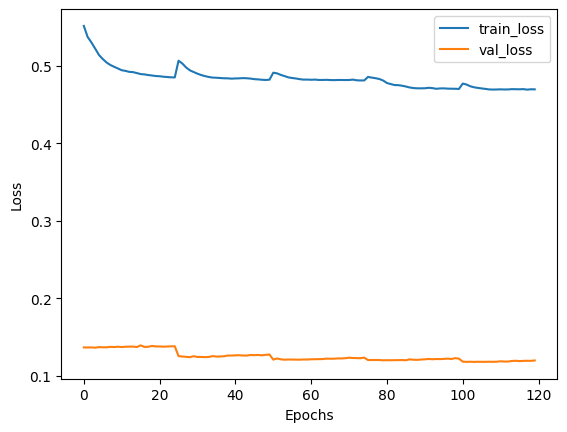

In [ ]:
from matplotlib import pyplot as plt
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/Cody - AIMI 2024/Trains/train_val_loss.png')
plt.show()


# Evaluating on Test Dataset


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Resnext50(num_classes)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

checkpoint = torch.load(r'/content/drive/MyDrive/Cody - AIMI 2024/Trains/Run_2/best.ckpt')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def getImage(image_path):
  image = Image.open(image_path).convert("RGB")
  image = test_transforms(image)
  return image

In [ ]:
threshold = 0.5

def predict(model, image_tensor):
  model.eval()
  with torch.no_grad():
      input = image_tensor.unsqueeze(0)  #image lacks batch layer, so insert a batch dimension of size 1
      input = input.to(device)

      outputs = model(input).cpu()
      preds = np.array(outputs)

      rounded_preds, thresholded_preds = np.empty_like(preds), np.empty_like(preds)
      rounded_preds[:] = preds
      thresholded_preds[:] = preds

      for(i, pred) in enumerate(preds):
              thresholded_preds[i] = (pred > threshold).astype(int)
              if(np.all(thresholded_preds[i] == 0)):
                thresholded_preds[i] = [0, 0, 0, 1]
              rounded_preds[i] = [round(num, 7) for num in pred]

      return thresholded_preds[0], rounded_preds[0]


In [ ]:
test_dataframe = pd.read_csv("/content/drive/MyDrive/Cody - AIMI 2024/2024 AIMI Summer Internship - Intern Materials/Datasets/test_annotations.csv")
os.chdir(r'/content/student_data_split')

In [ ]:
#np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

processed_patients = []
#number_pneumonia = 0 #temporary just to double check

for index, row in tqdm(test_dataframe.iterrows(), total=test_dataframe.shape[0]):
  images = os.listdir(row['study_id'])
  for image in images:
    thresholded_preds, rounded_preds = predict(model, getImage(row['study_id'] + '/' + image))

    patient = {
        'study_id' : row['study_id'],
        'Pneumothorax' : thresholded_preds[1],
        'Pneumonia' : thresholded_preds[0],
        'Pleural Effusion' : thresholded_preds[2],
        'No Finding' : thresholded_preds[3],
        'Pneumothorax Probs' : rounded_preds[1],
        'Pneumonia Probs' : rounded_preds[0],
        'Pleural Effusion Probs' : rounded_preds[2],
        'No Finding Probs' : rounded_preds[3],
    }

    #temporary, check # of pneumonia to make sure not exporting wrong
    #if(thresholded_preds[0] == 1):
    #  number_pneumonia += 1

    processed_patients.append(patient)

    break # too lazy to deal/combine output from multiple images for now, will handle later

#print(f"\n {number_pneumonia} pneumonia detected")

100%|██████████| 2983/2983 [01:11<00:00, 41.45it/s]


In [ ]:
test_processed_dataframe = pd.DataFrame(processed_patients)
test_processed_dataframe.to_csv(r'/content/drive/MyDrive/Cody - AIMI 2024/test_results.csv', index=False, float_format='%.10f')

# Submitting Your Results
Once you have successfully trained your model, generate predictions on the test set and save your results as a `.csv` file. This file can then be uploaded to the leaderboard: https://vilmedic.app/misc/aimi24/leaderboard.

An example `test_results.csv` has been provided for reference only in the `2024 AIMI Summer Internship - Intern Materials/Datasets/Labels` folder. *Do not submit this, the results will be really poor. *

Your final `.csv` file **must** have the following format:
- There must be a column titled `study_id` with the paths to the study_id for the test set image, e.g. `student_test/patient35172/study3`.
- The provided columns from `test_annotations.csv` must be present: "Pneumothorax", "Pneumonia", "Pleural Effusion", "No Finding:
  - Each of these columns must contain a binary value `0` or `1` representing the **observed/ground-truth** absence or presence of the disease status.
- Added columns "Pneumothorax Probs", "Pneumonia Probs", "Pleural Effusion Probs", "No Finding Probs" containing the singular probability values belonging to each class.
  - Each of these columns must contain a continuous value representing the **predicted** probability of the absence or presence of the disease status for that class.
  - *Hint:* Depending on which loss function you used, you might already be outputing probabilities. You can then derive predictions by thresholding your probabilities to a binarized output. If your model outputs logits directly, then apply the sigmoid activation function `torch.sigmoid(logits)` to get probabilities and then threshold to get binary predictions.
- Double check that the length of the dataset passed into your dataloader matches the length of your final dataframe.

In [ ]:
model = # Model Architecture
ckpt = torch.load("/content/best.pkl")
model.load_state_dict(ckpt["state_dict"])

test_dataset = ChestXRayDataset("""Fill in args here""")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, drop_last=False)

In [ ]:
# Write method to load in data from test_loader, compute model predictions, and append results to test_results dict
test_results = {"image_path": [], "pred": []}

In [ ]:
test_results = pd.DataFrame(test_results)
test_results.to_csv(f"/content/test_results.csv")